# Почистим данные перед визуализацией

На момент скачивания таблицы была ночь с 4 февраля на 5 февраля, тогда было 2531 запись, добавляются они в начало, поэтому беру количество записей с (количество всех записей - 2531) элемента

In [112]:
import pandas as pd
from ztfquery import lightcurve
import time
import numpy as np
from tqdm import tqdm
from PyAstronomy import pyasl
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib
from matplotlib import pyplot as plt


path = "https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&classexclude=&quality=y&purity=y&ztflink=lasair&lastdet=&startsavedate=&startpeakdate=&startra=&startdec=&startz=&startdur=&startrise=&startfade=&startpeakmag=&startabsmag=&starthostabs=&starthostcol=&startb=&startav=&endsavedate=&endpeakdate=&endra=&enddec=&endz=&enddur=&endrise=&endfade=&endpeakmag=19.0&endabsmag=&endhostabs=&endhostcol=&endb=&endav=&reverse=y&format=csv"
df_ztf = pd.read_csv(path, sep =',')
count_row = df_ztf.index.values.shape[0]
df_ztf = df_ztf[(count_row-2531):]
path_df = '/home/masha/AstroAugumetation/DataFrames'
df_clean = []
numbers = []
for i in range(0, 2531):
    
    try:
        data = pd.read_csv(path_df+"/{}.csv".format(i), sep =',')
        #оставим только данные с положительными ошибками и catflags = 0
        data = data[(data['magerr'] > 0) & (data['catflags'] == 0)]
        
        #непустые датафреймы смотрим далее
        if data.index.values.shape[0] != 0:
            peak_date = np.round(df_ztf[:(i+1)]['peakt'].values[i], 3)
            ra = df_ztf[:(i+1)]['RA'].values[i]
            dec = df_ztf[:(i+1)]['Dec'].values[i]
            ra_dec = SkyCoord(' '.join([ra, dec]), unit=(u.hourangle, u.deg))
            mjd = pyasl.helio_jd(peak_date + 2458000 - 2.4e6, ra_dec.ra.deg, ra_dec.dec.deg)
            #проверим, что дата пика (с точностью до дня) попадает в датафрейм
            if np.any(np.round(mjd, 0) in np.round(data['mjd'].values, 0)):
            #далее идёт проверка, что звездная величина пика+-0.5 попадает в скачанный датафрейм
                peak = np.round(df_ztf[:(i+1)]['peakmag'].values[i], 3)
                EPS = 0.5
                checker = 0
            
                for elem in np.round(np.arange(peak-EPS,peak+EPS, 0.001), 3):
                
                    if elem in np.round(data['mag'], 3):
                        checker += 1
                
                if checker > 0:
                    df_clean.append(data)
                    numbers.append(i)
                
    except FileNotFoundError:
        continue


<ipython-input-131-92b77a1d873a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


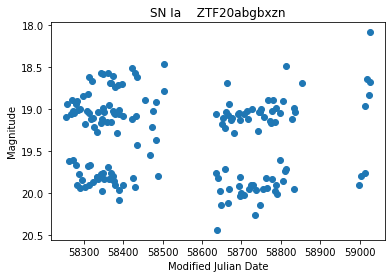

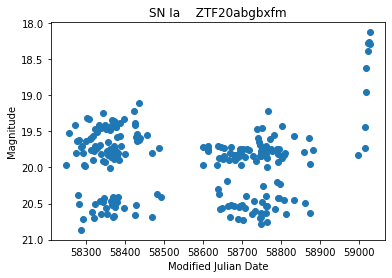

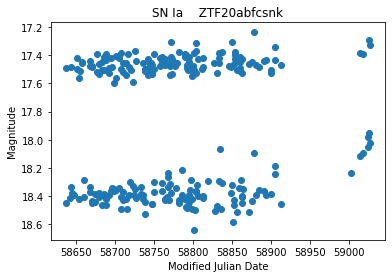

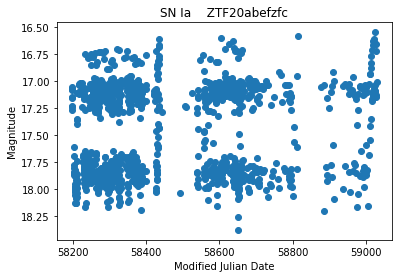

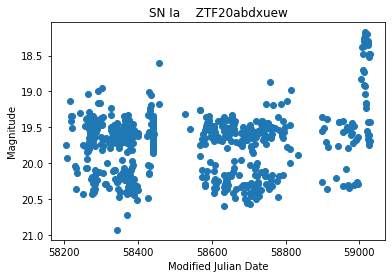

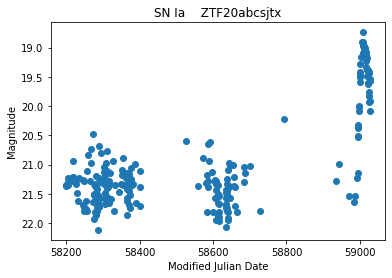

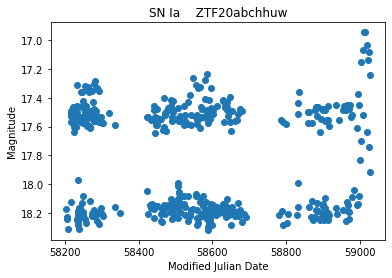

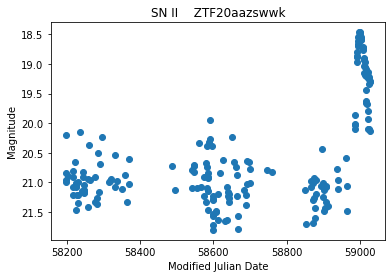

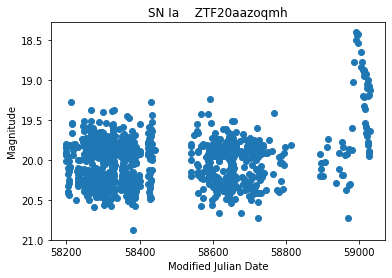

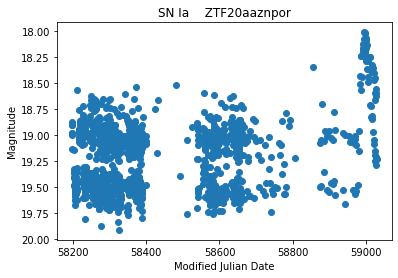

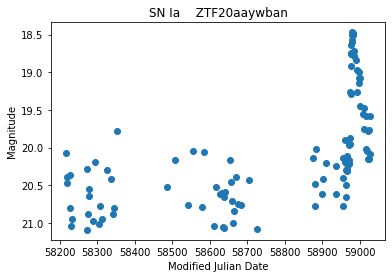

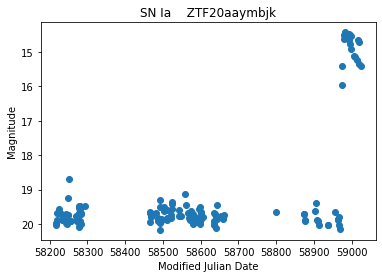

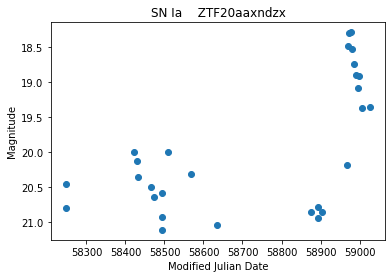

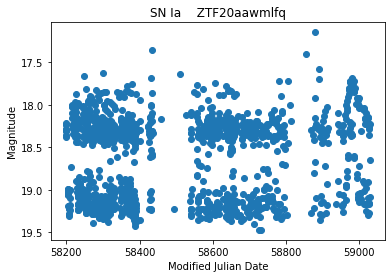

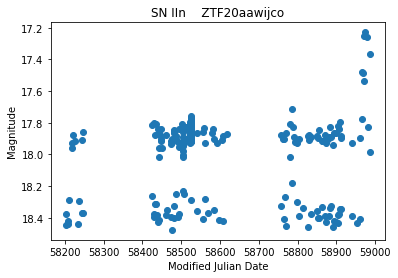

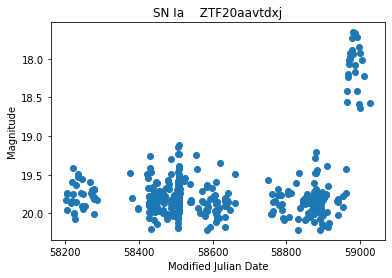

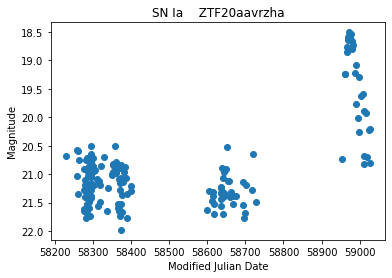

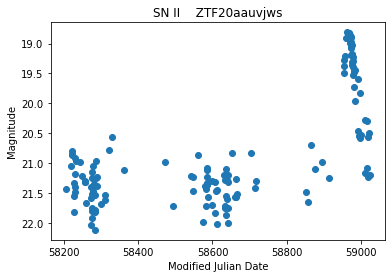

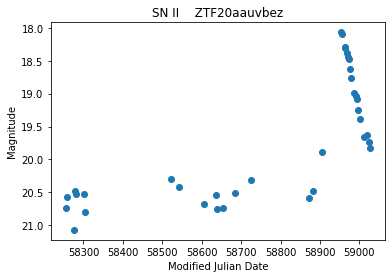

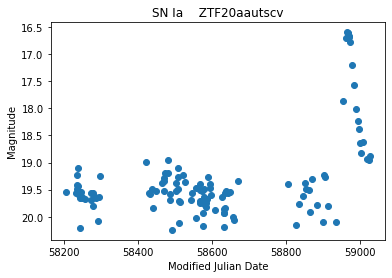

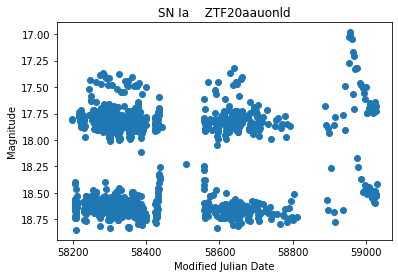

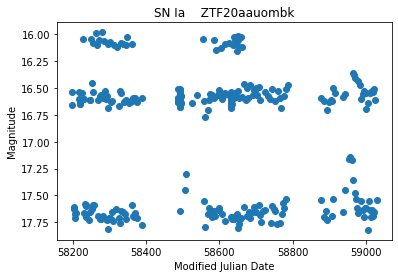

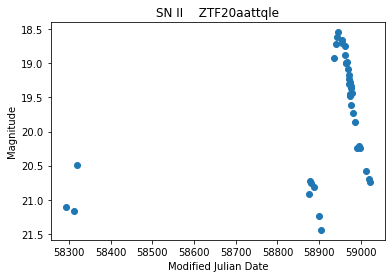

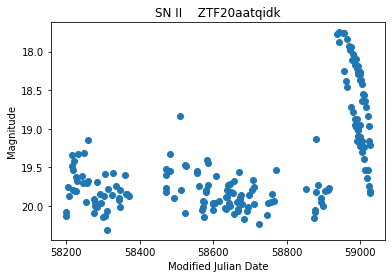

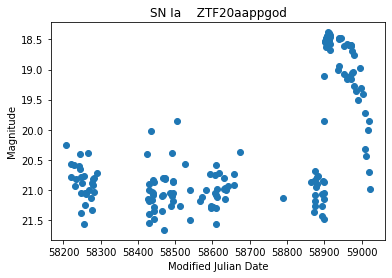

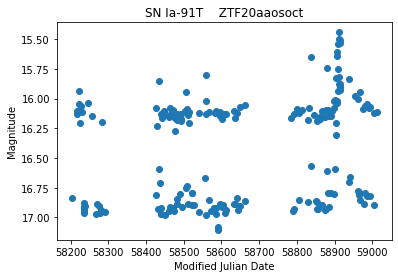

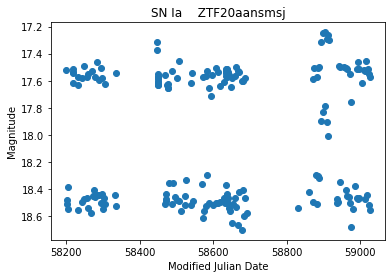

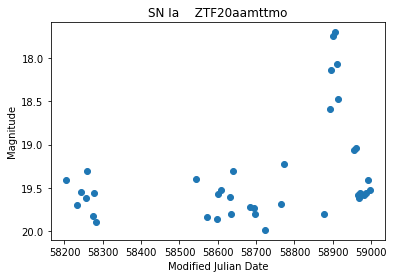

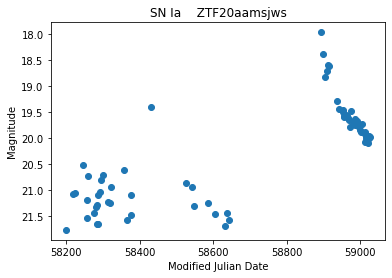

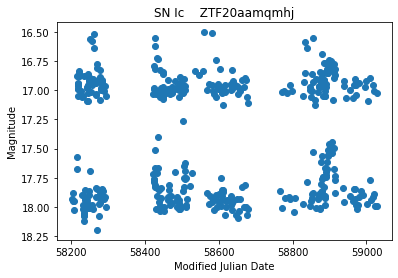

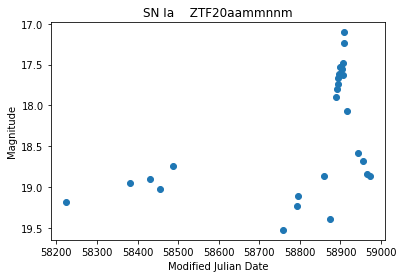

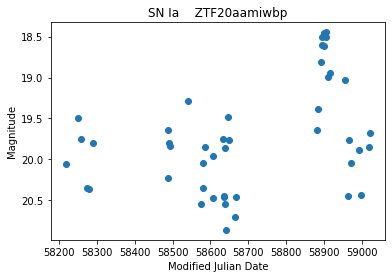

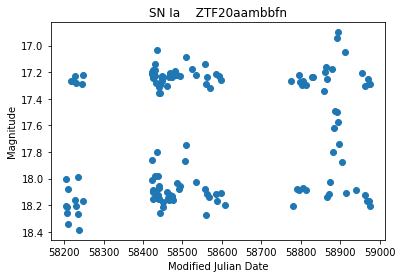

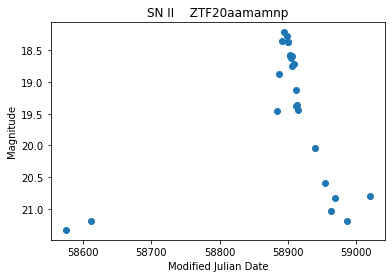

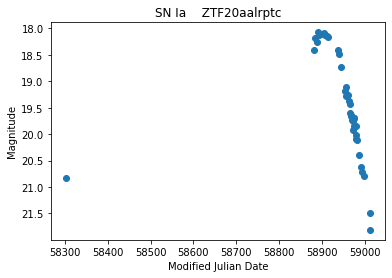

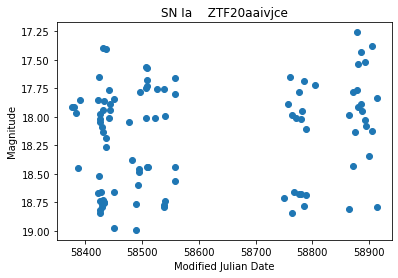

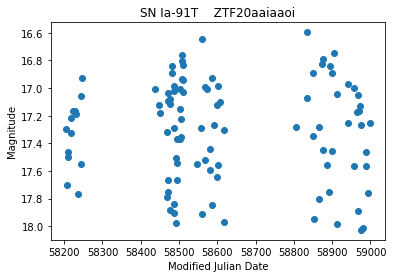

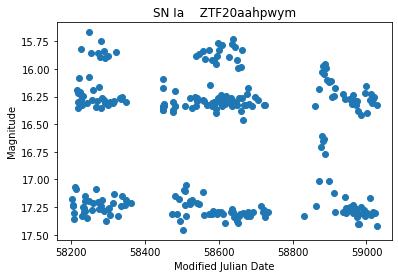

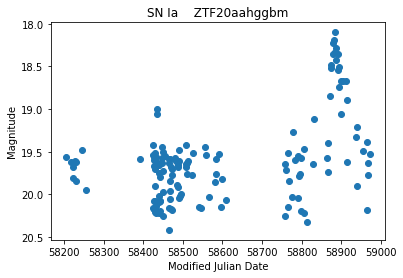

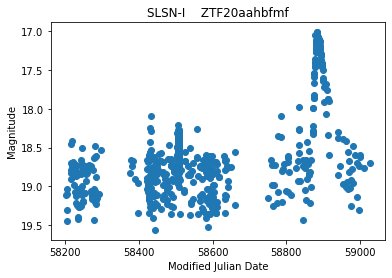

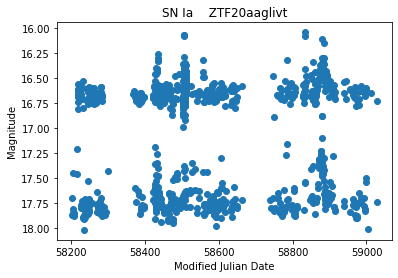

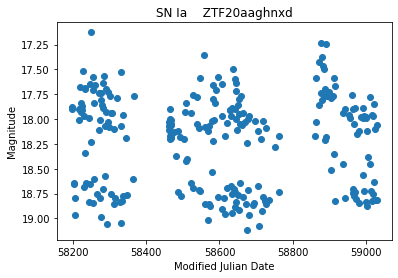

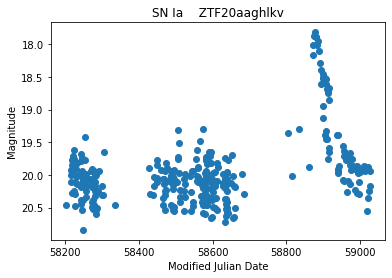

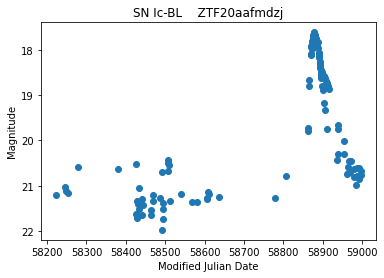

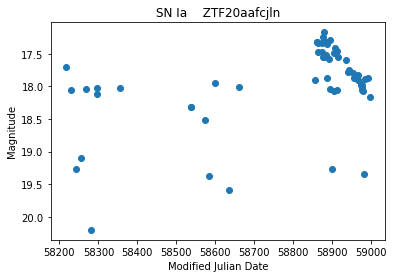

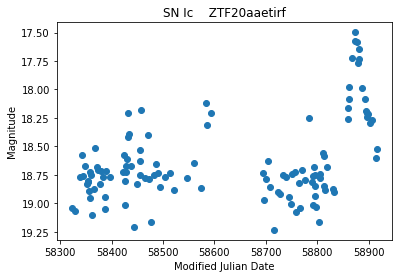

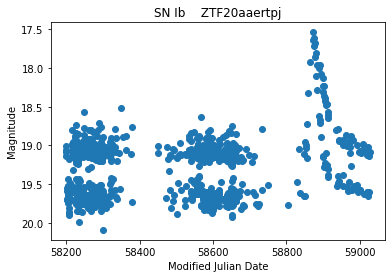

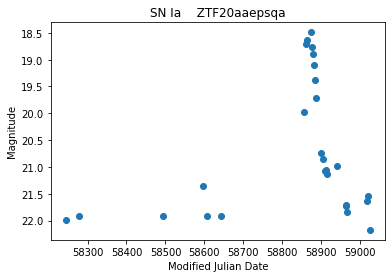

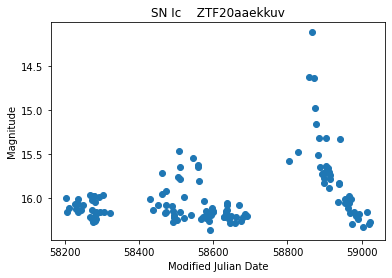

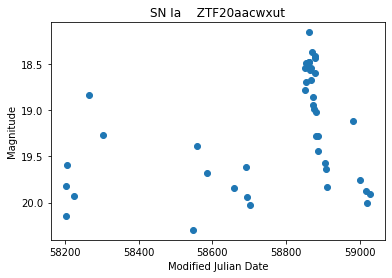

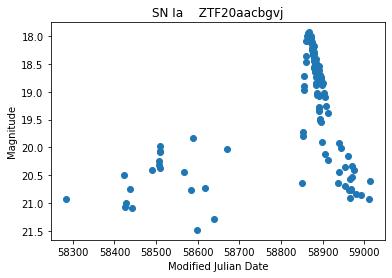

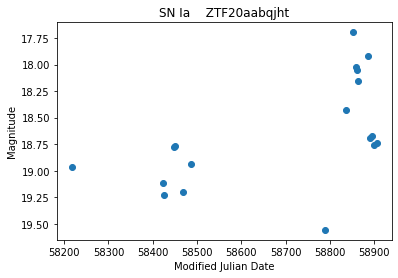

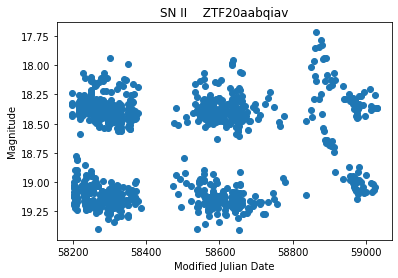

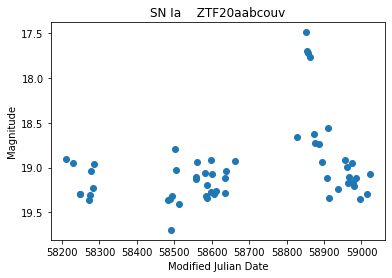

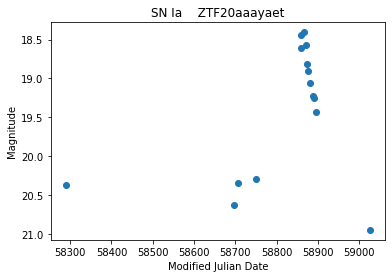

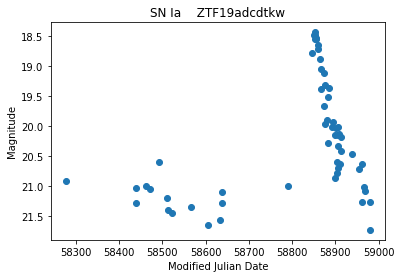

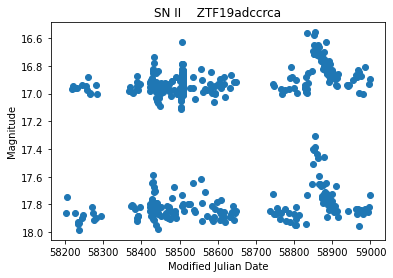

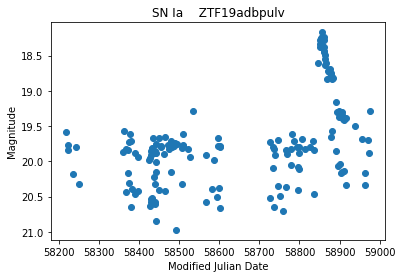

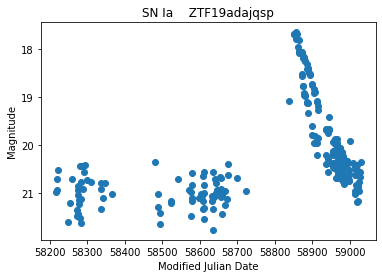

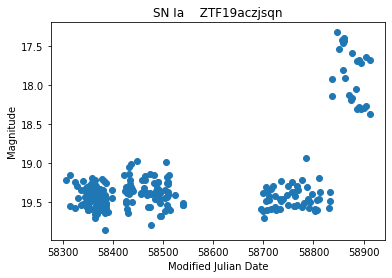

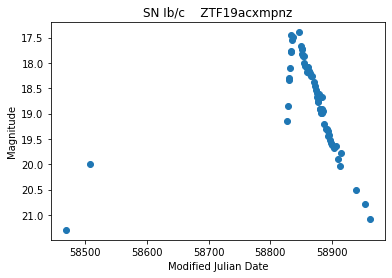

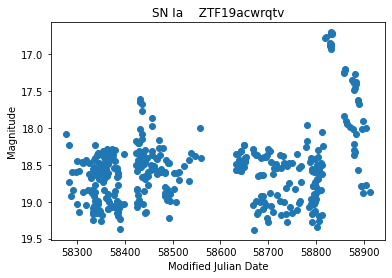

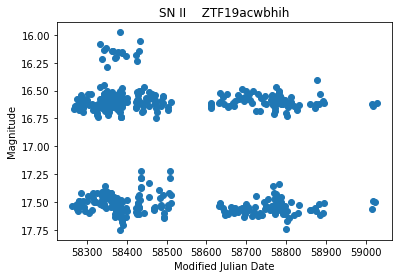

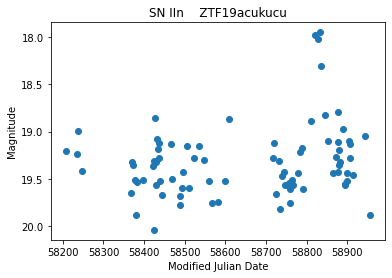

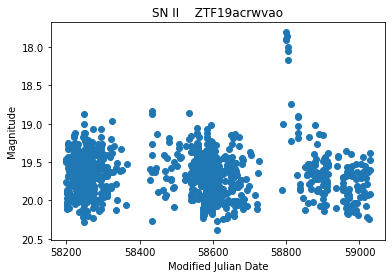

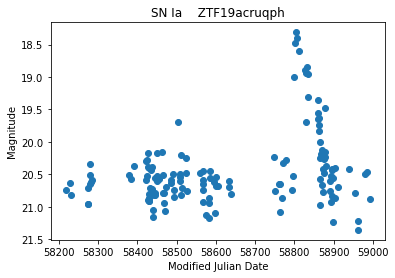

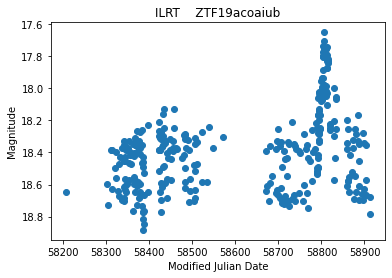

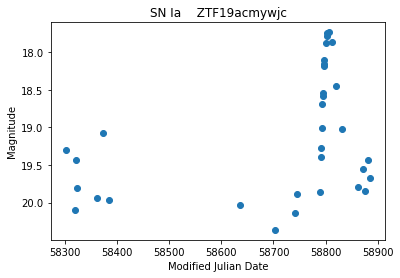

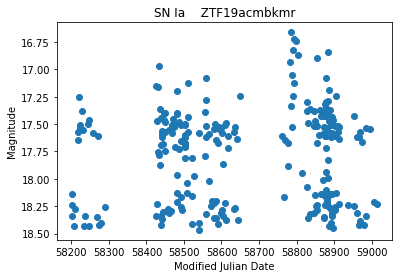

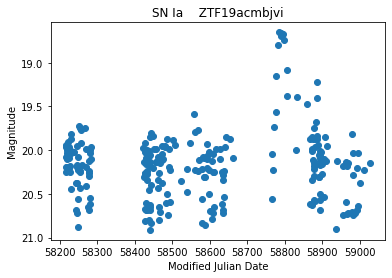

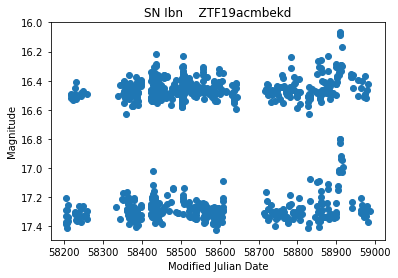

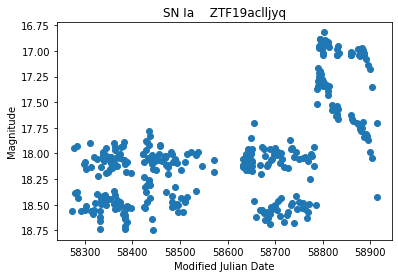

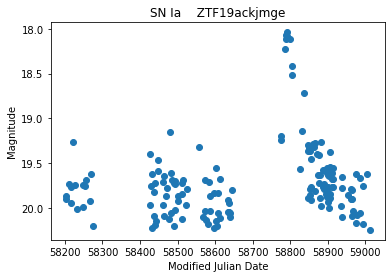

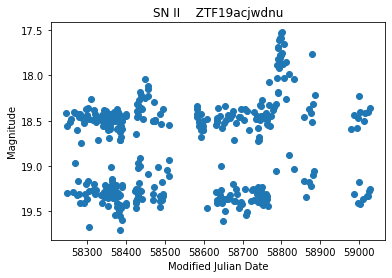

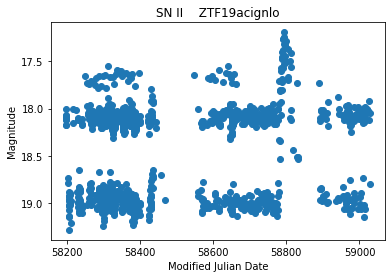

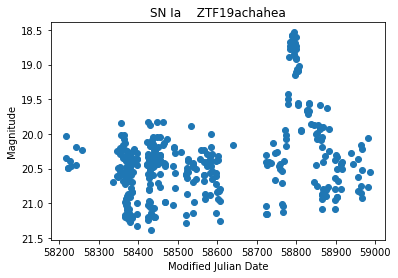

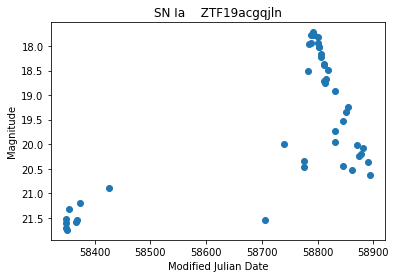

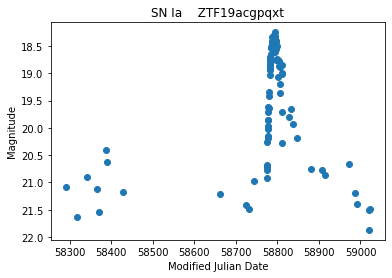

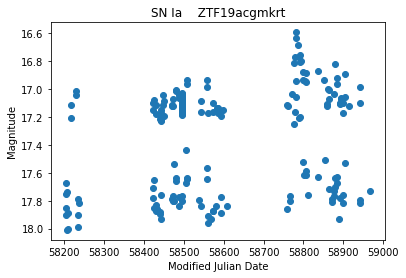

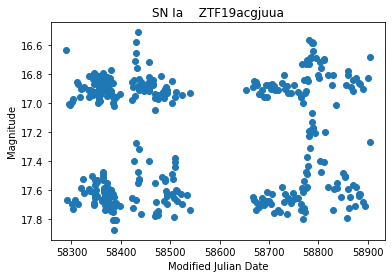

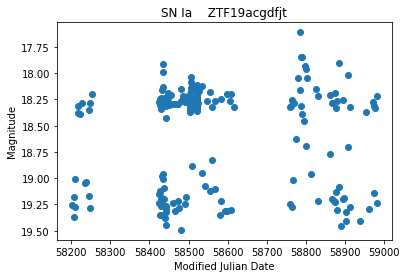

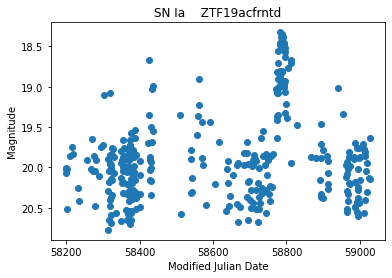

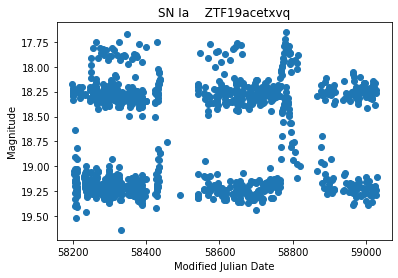

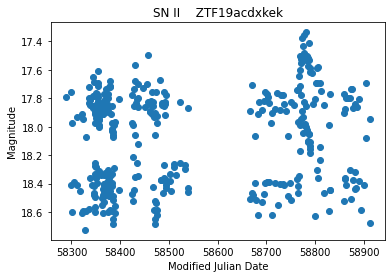

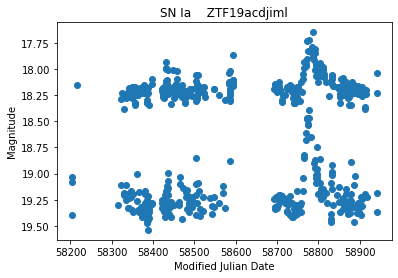

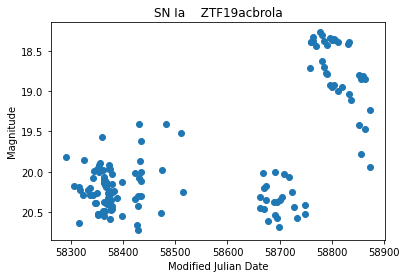

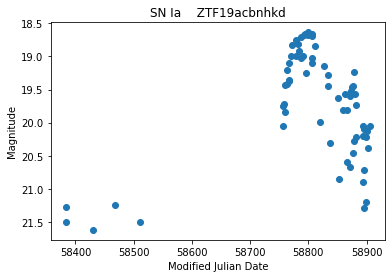

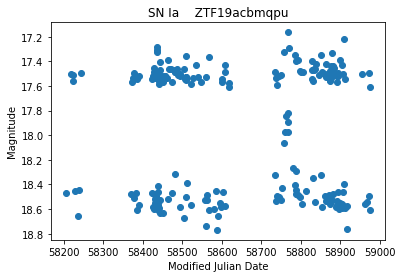

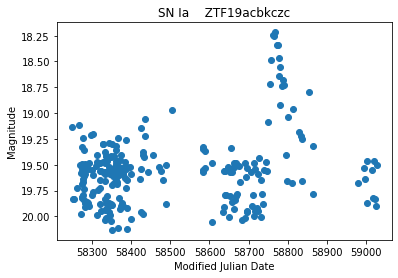

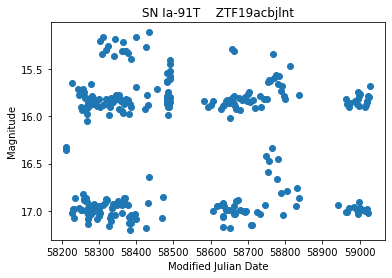

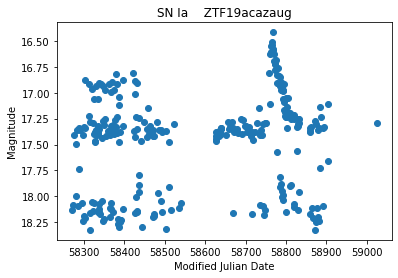

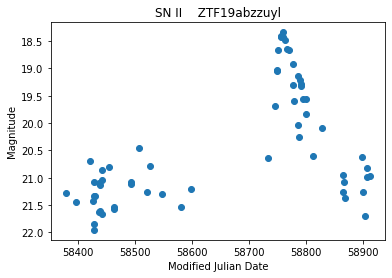

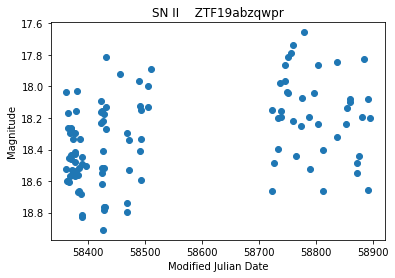

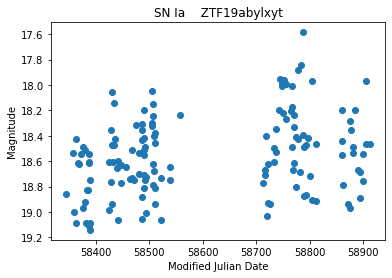

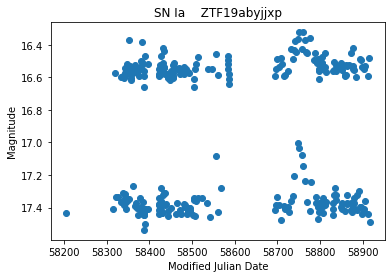

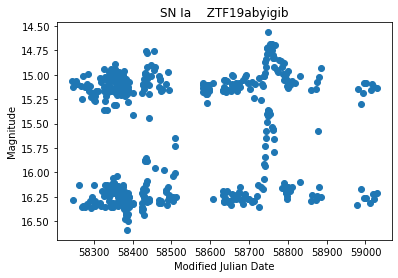

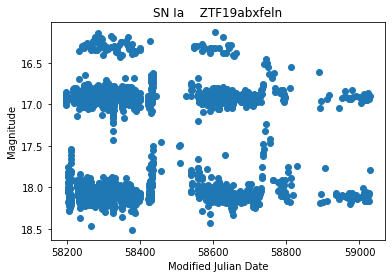

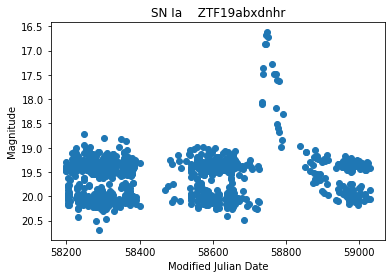

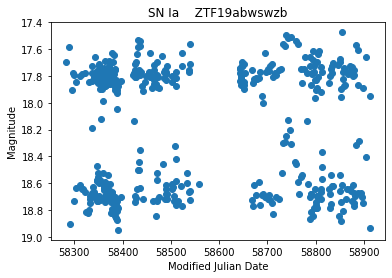

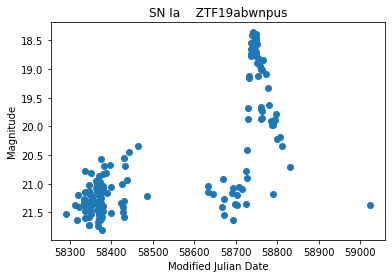

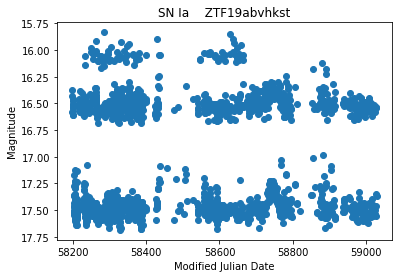

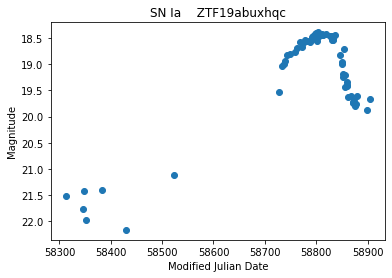

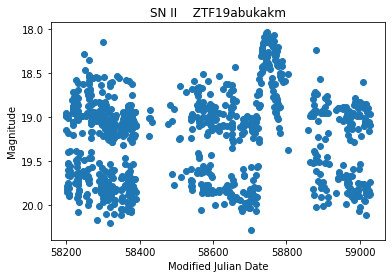

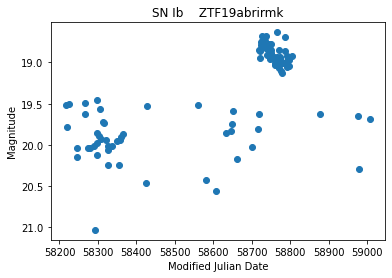

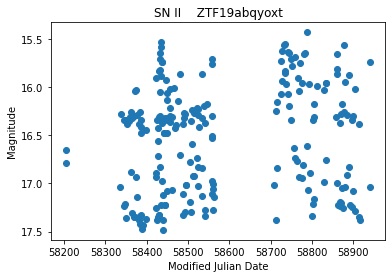

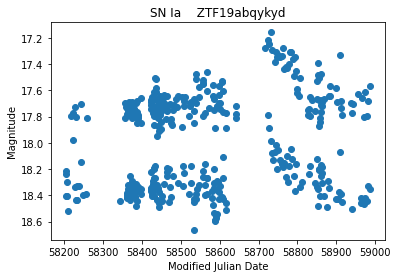

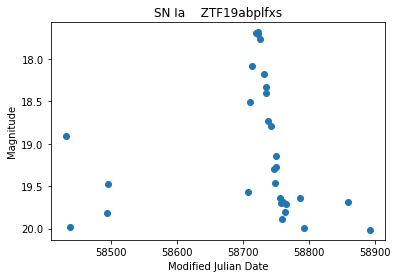

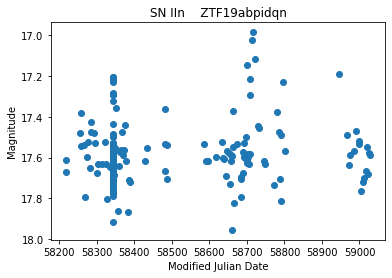

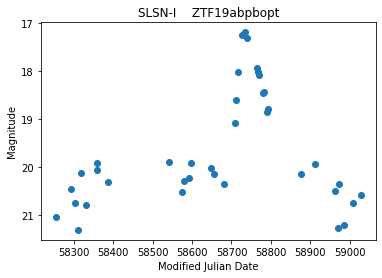

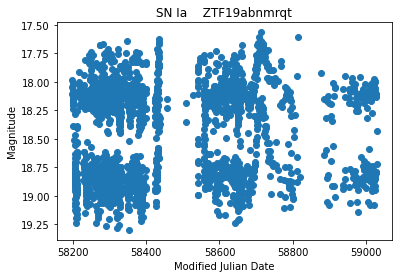

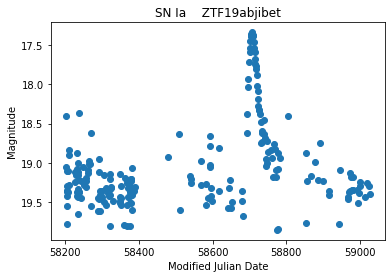

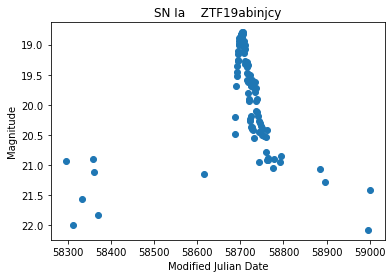

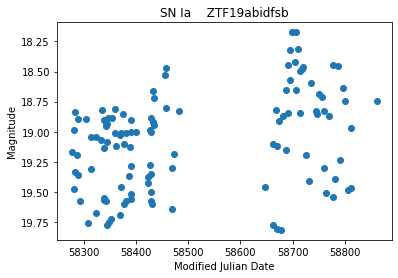

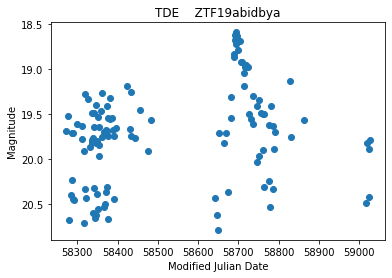

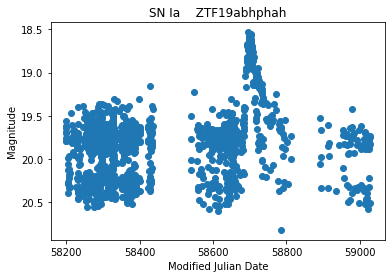

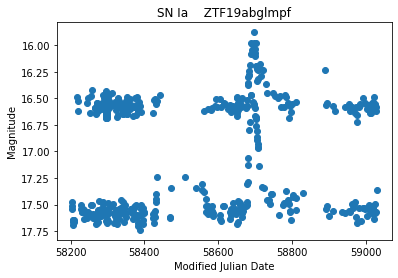

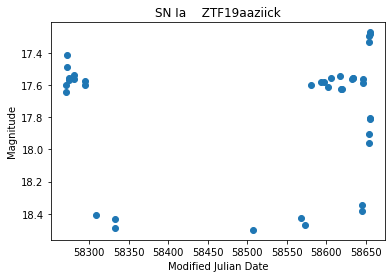

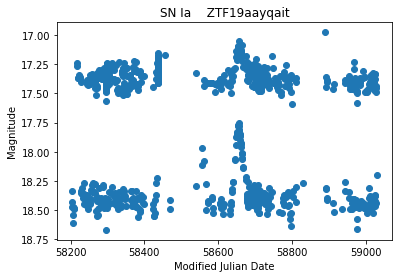

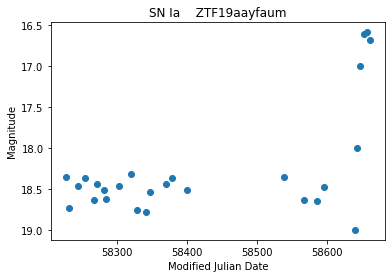

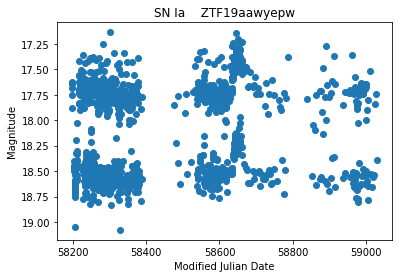

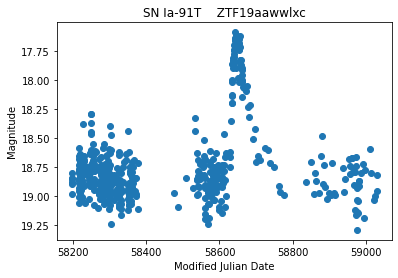

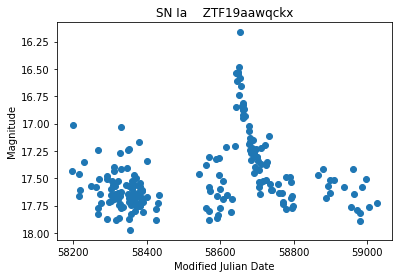

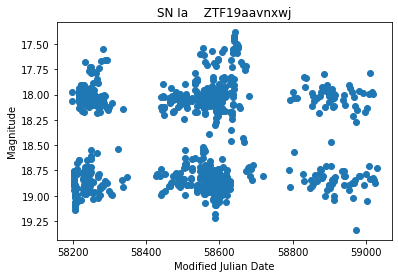

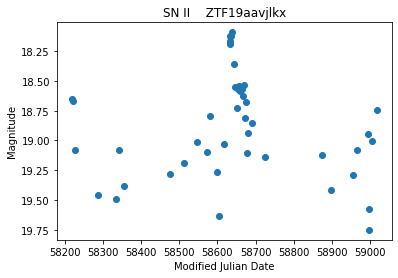

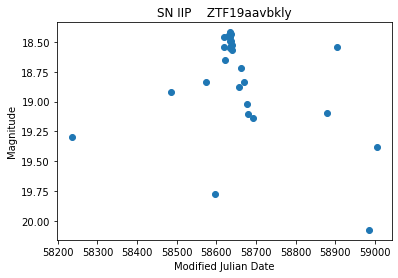

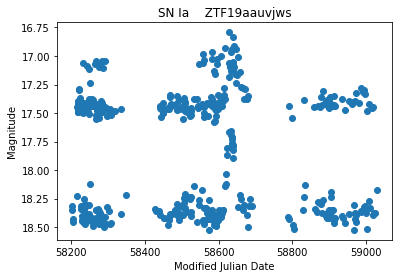

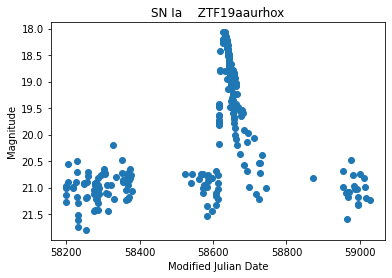

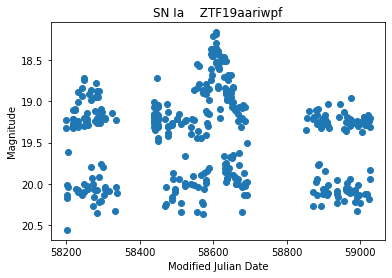

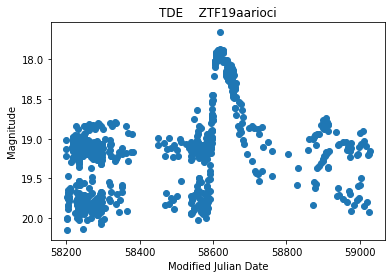

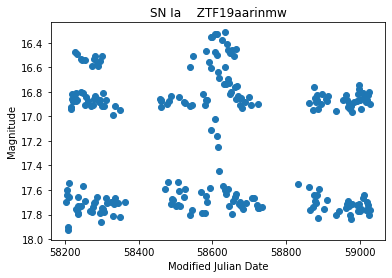

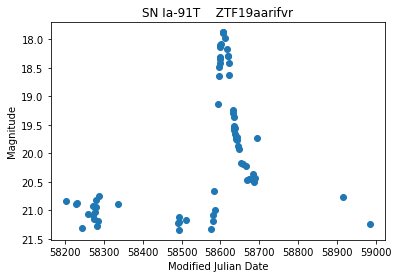

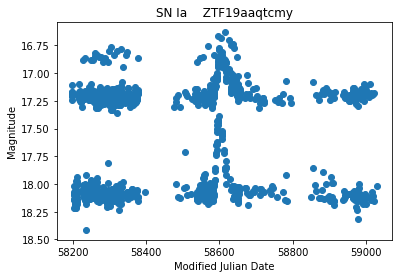

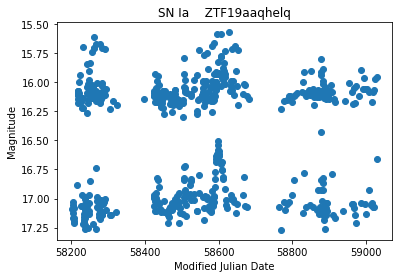

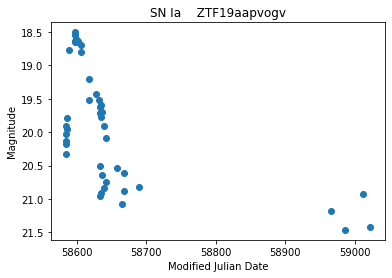

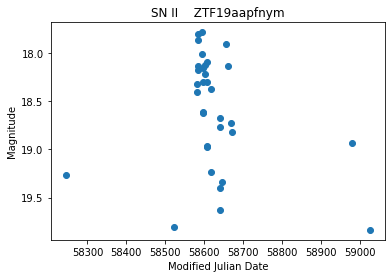

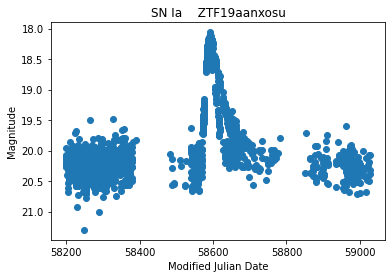

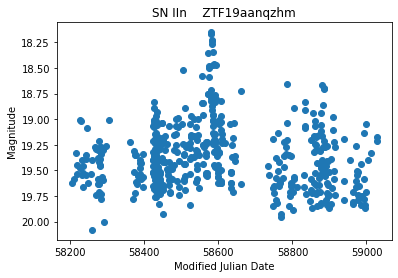

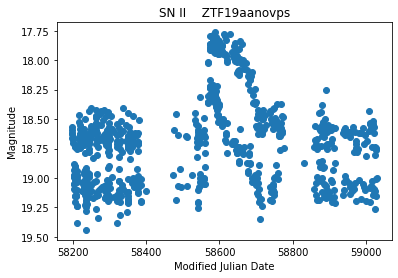

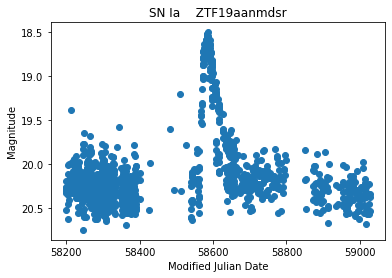

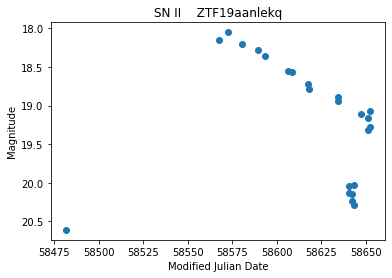

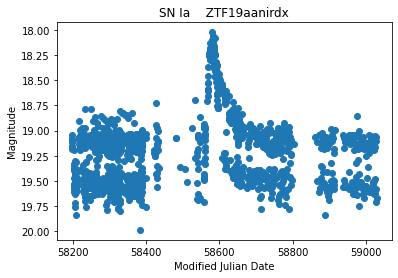

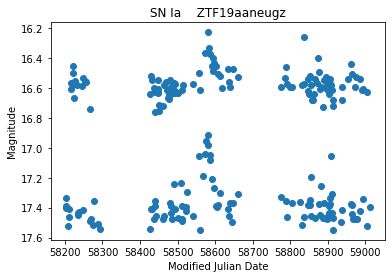

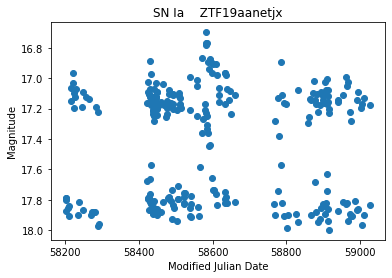

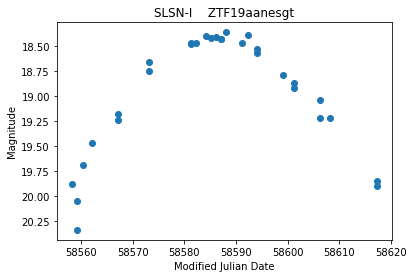

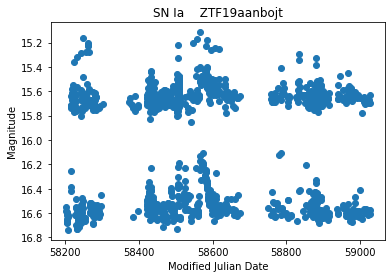

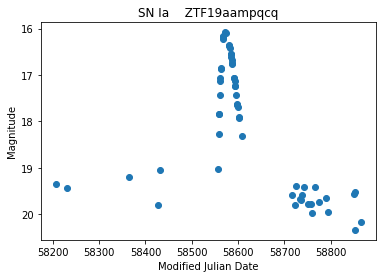

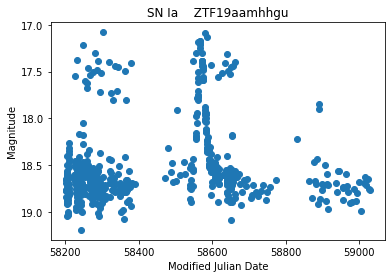

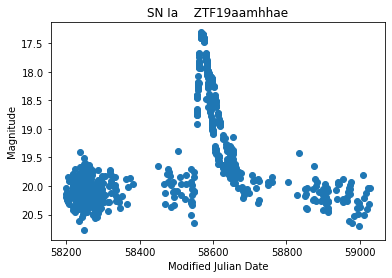

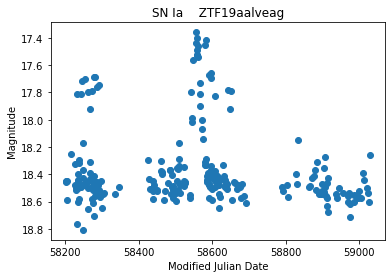

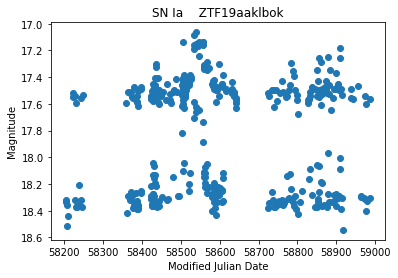

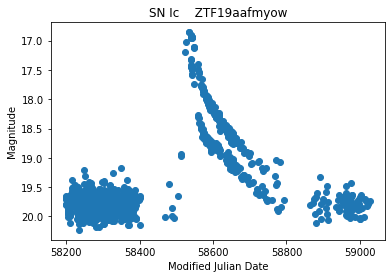

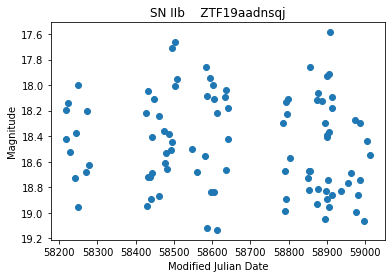

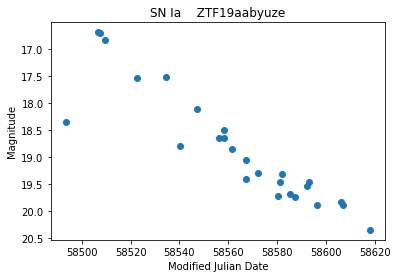

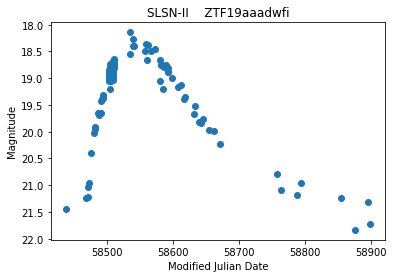

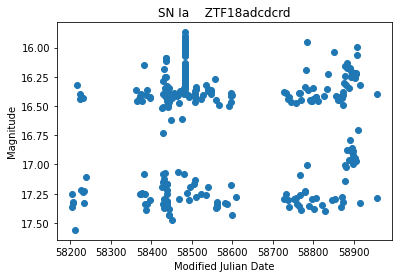

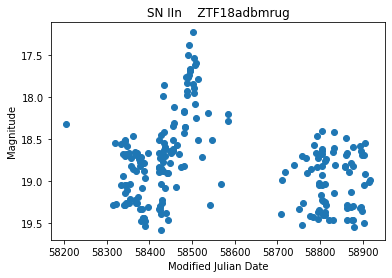

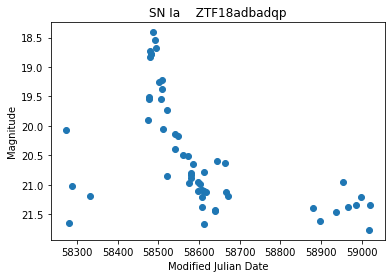

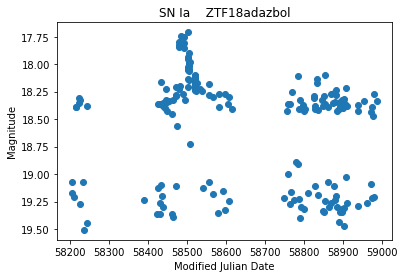

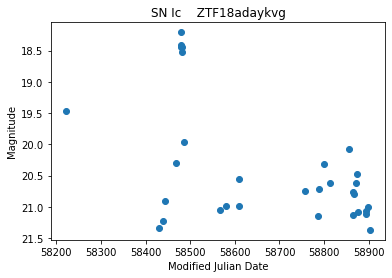

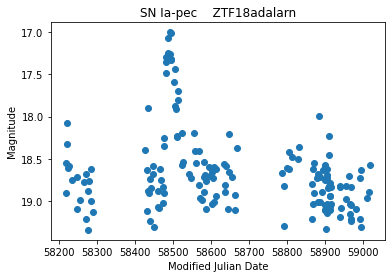

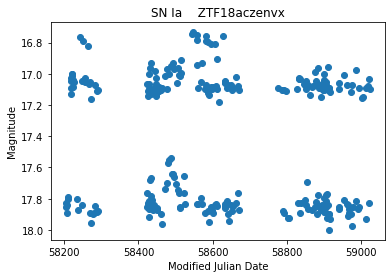

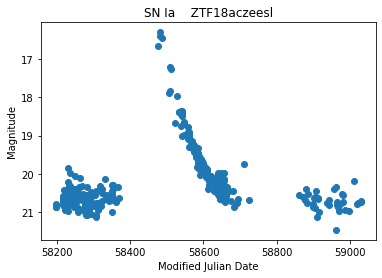

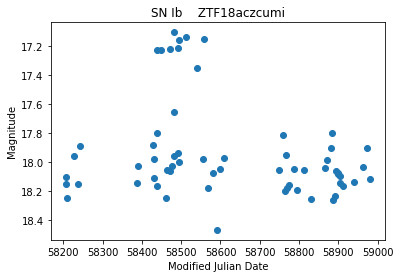

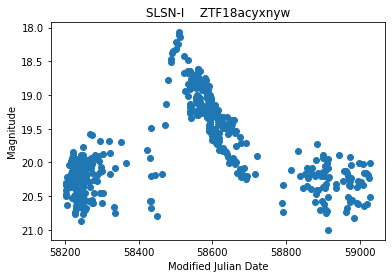

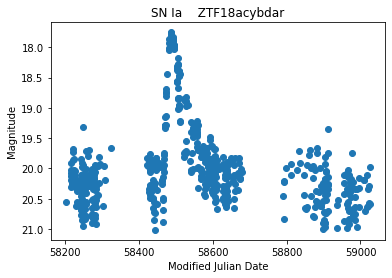

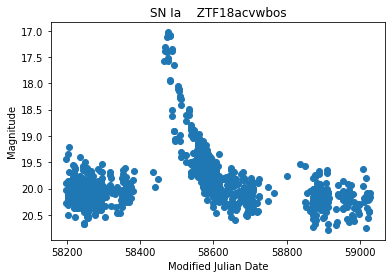

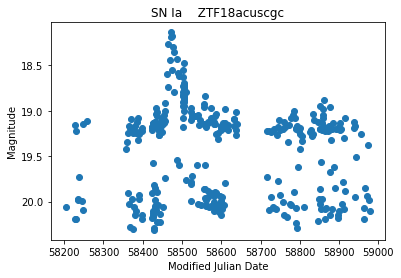

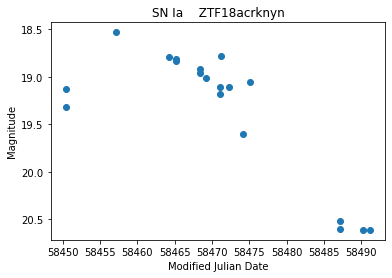

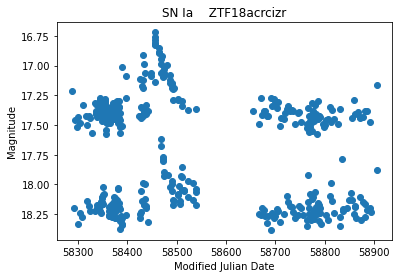

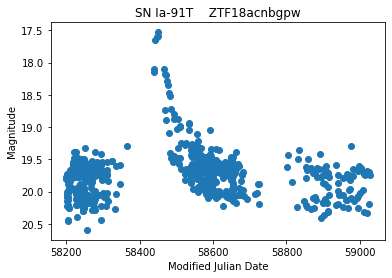

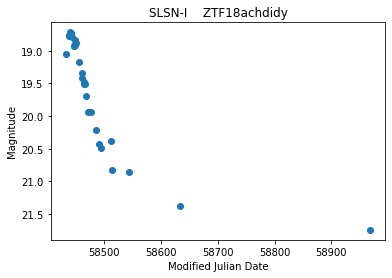

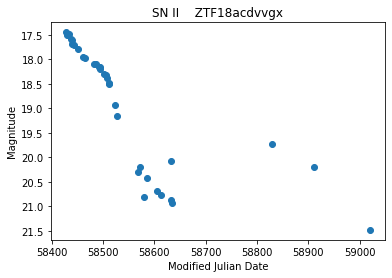

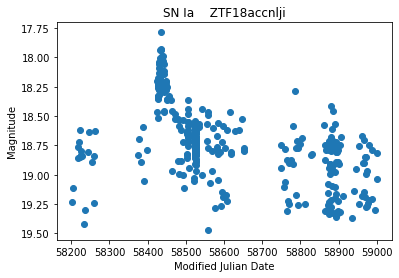

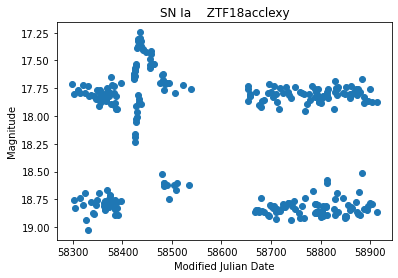

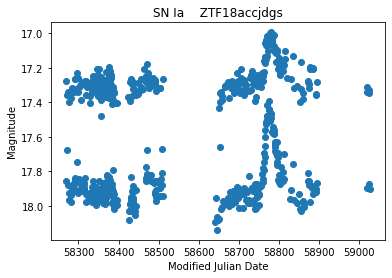

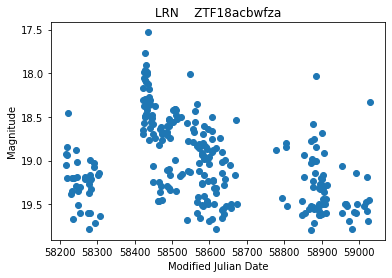

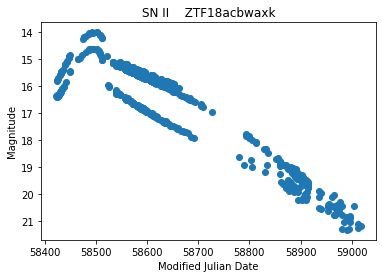

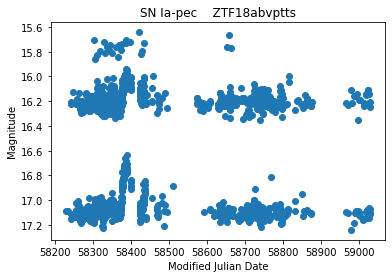

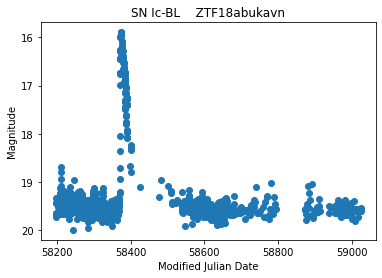

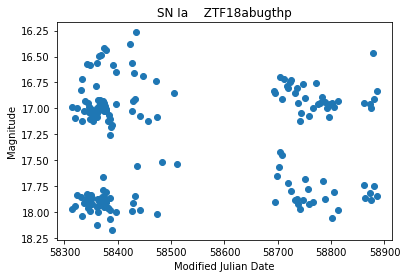

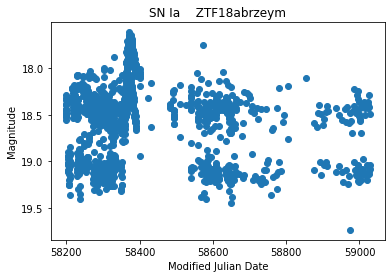

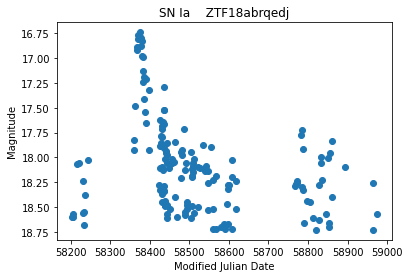

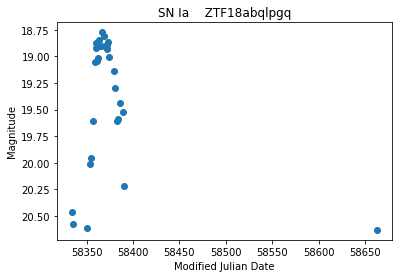

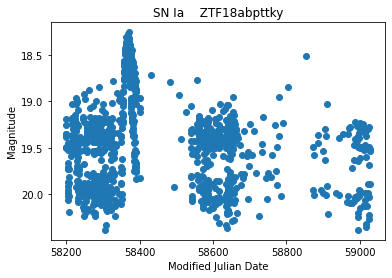

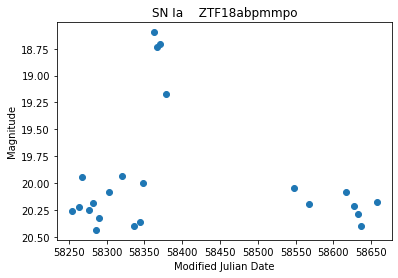

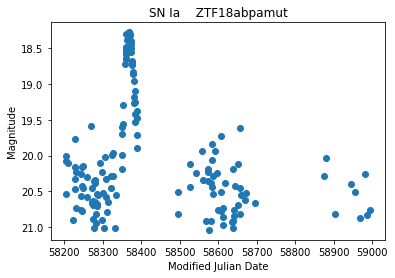

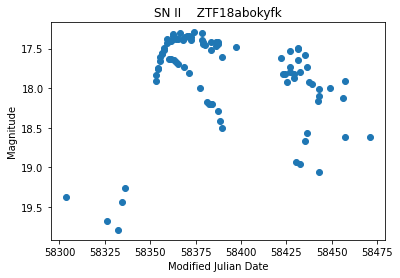

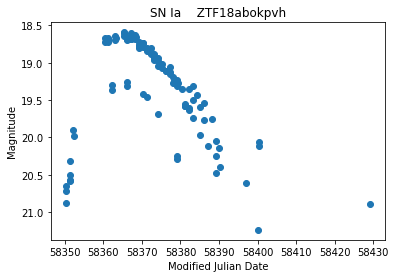

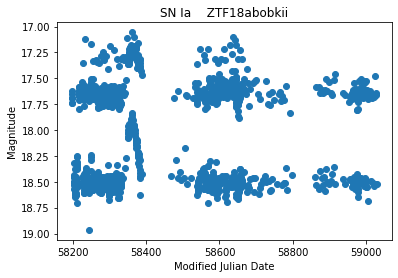

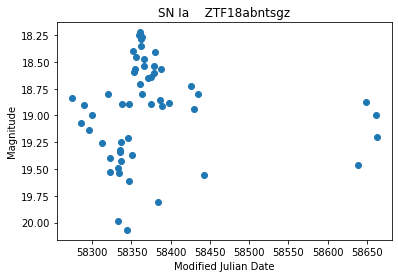

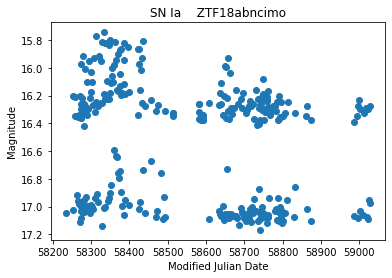

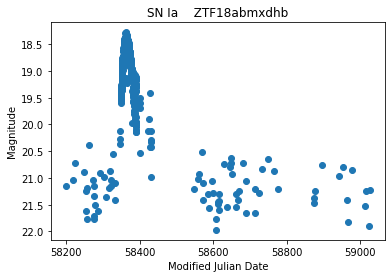

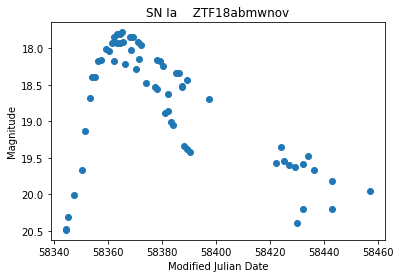

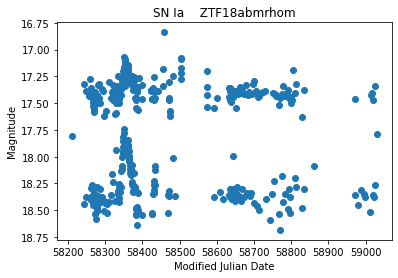

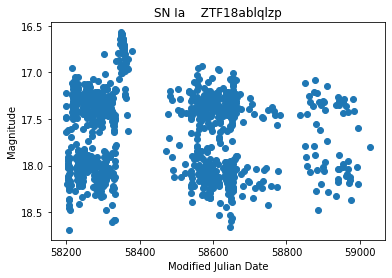

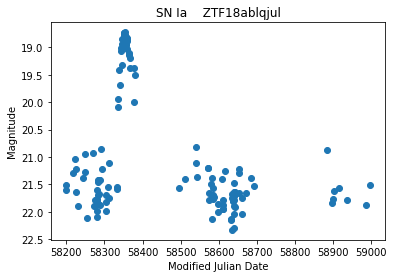

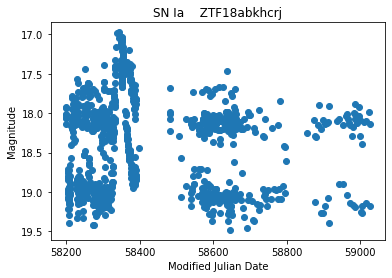

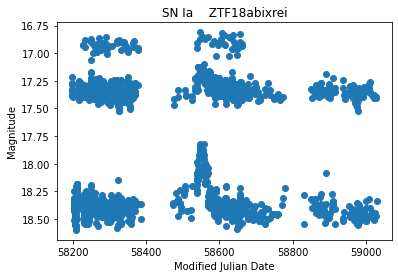

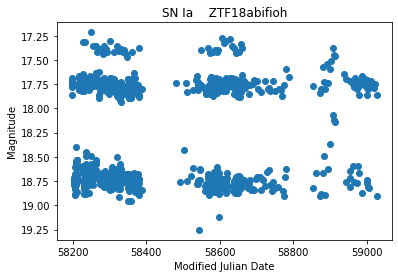

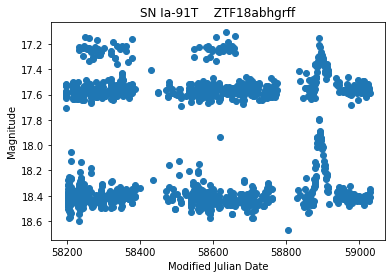

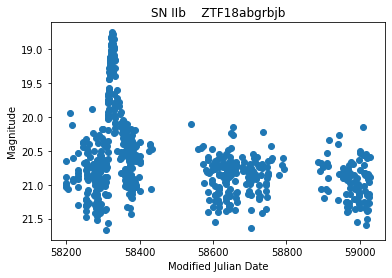

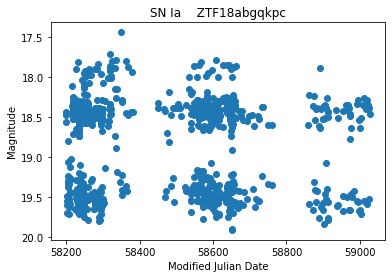

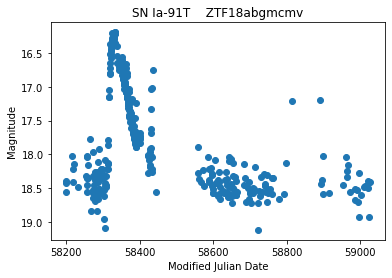

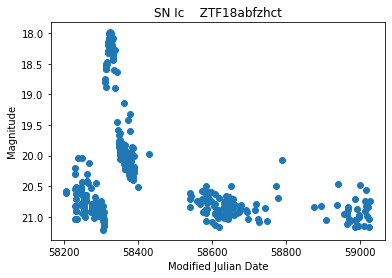

In [ ]:
for i in range(len(df_clean)):
    plt.figure()
    plt.gca().invert_yaxis()
    index_in_ztf = numbers[i]
    type_of_supernova = df_ztf[:(index_in_ztf + 1)]['type'].values[index_in_ztf]
    name_of_supernova = df_ztf[:(index_in_ztf + 1)]['ZTFID'].values[index_in_ztf]
    plt.title(type_of_supernova + "    " + name_of_supernova)
    plt.ylabel('Magnitude')
    plt.xlabel('Modified Julian Date')
    #plt.ylim(max(df_clean[i]['mag'].values), min(df_clean[i]['mag'].values)) 
    plt.plot(df_clean[i]['mjd'].values, df_clean[i]['mag'].values, 'o')